In [1]:
import pandas as pd
import wikipediaapi
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import nltk

## DATA COLLECTION ##########################################################################

In [2]:
def collectBiographiesFromCategories(categorymembers, category, data, number_people, level=0, max_level=1): 
    """
    Recursively collects biographical texts and fact graphs for each person in specified Wikipedia category members up to a given recursion level.

    Parameters:
        categorymembers (dict): A dictionary of category member pages from the WikipediaAPI.
        category (str): The name of the category being processed.
        data (list): A list to store biographical text and associated metadata.
        number_people (int): Counter for the number of biographies collected.
        level (int): Current level of recursion through category members.
        max_level (int): Maximum depth of recursion allowed.

    Returns:
        int: Updated count of processed biographies.
    """

    for page in categorymembers.values():
        if page.ns == 0 and 'List' not in page.title and number_people < 3: #limit the number of people for each category to 130

            #some wikipedia page cannot be found in dbpedia, we ignore them
            try: 

                #knowledge graph of facts
                kg_graph = fetchDbpediaFacts(page.pageid, page.title)
                # Save the graph of facts to a JSON file
                with open('knowledge_graph.json', 'a') as json_file:
                    json.dump(kg_graph, json_file, indent=4)
                print(f"{category} {page.title} processed")


                text = page.text
                data.append({'text': text, 'category': category})
                #creation of txt file for the biography
                f = open(f"Biographies_{category}/{(page.title).replace(' ', '')}_{category}.txt", "w", encoding='utf-8')
                f.write(text)
                f.close()

                #keep track of people processed
                number_people += 1  

            except Exception as err:
                print(f"Unexpected {err=}, {type(err)=}, could not process {page.title}")
                continue


        if page.ns == wikipediaapi.Namespace.CATEGORY and level < max_level and number_people < 3: #change to 130
            # Recursively call the function to process pages in the subcategory 
            number_people = collectBiographiesFromCategories(page.categorymembers, category, data, number_people, level=level + 1, max_level=max_level)
    # return updated count of processed people
    return number_people

In [3]:
def createBiographyDataFrames():
    """
    Collects biographical data from Wikipedia categories 'Sculptors' and 'Journalists', 
    creates directories for storing these biographies, and formats the collected data into a pandas DataFrame.

    Returns:
        DataFrame: A pandas DataFrame containing the text and category of each biography collected.
    """
    
    os.chdir('/Users/abigail.berthe/OneDrive/M1_TAL/S2/Data_Science/m1-datascience-project/src')
    
    wiki = wikipediaapi.Wikipedia('Mozilla/5.0', 'en')

    data = []
    
    sculptors = wiki.page("Category:Sculptors")
    if not os.path.exists('Biographies_Sculptors'):
        os.mkdir('Biographies_Sculptors') #creates a directory to store all sculptors' biographies
    collectBiographiesFromCategories(sculptors.categorymembers, "Sculptors", data, 0)
    

    journalists = wiki.page("Category:Journalists")
    if not os.path.exists('Biographies_Journalists'):
        os.mkdir('Biographies_Journalists') #creates a directory to store all journalists' biographies
    collectBiographiesFromCategories(journalists.categorymembers, "Journalists", data, 0)

    df = pd.DataFrame(data)
    return df

In [4]:
def fetchDbpediaFacts(wiki_id, page_title):
    """
    Fetches RDF triples (facts) about a specific Wikipedia page from DBpedia using the page's ID.

    Parameters:
        wiki_id (int): The Wikipedia page ID used to fetch the corresponding DBpedia page.
        page_title (str): Title of the Wikipedia page.

    Returns:
        dict: A dictionary containing RDF triples with DBpedia facts about the page, its title and other metadata.
    """

    #initialize the SPARQL wrapper
    sparql = SPARQLWrapper("http://dbpedia.org/sparql/")

    #first query to retrieve the dbpedia page of the person from the wikipedia page id
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            SELECT *
            WHERE {{
                    ?person dbo:wikiPageID {wiki_id} .
            }}
    """)
    sparql.setReturnFormat(JSON)
    result_link = sparql.query().convert()

    person_wikidata_page = result_link["results"]["bindings"][0]["person"]["value"] #the first value is most likely what we are looking for
    
    #second query to fetch all information as RDF triples
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            DESCRIBE <{person_wikidata_page}>
    """)
    sparql.setReturnFormat(JSON)
    results_facts = sparql.query().convert()
    results_facts['results']['bindings'] = (results_facts['results']['bindings'][:100]) #first 100 facts
    results_facts['head']['person'] = page_title.replace(" ", "")
    
    return(results_facts)

## DATA ANALYSIS ############################################################################

In [29]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import PorterStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


# Load Spacy English Model
nlp = spacy.load('en_core_web_sm')


def sentence_segmentation(spacy_text):
    list_of_sentences = []
    for s in spacy_text.sents:
        list_of_sentences.append(s)
    return list_of_sentences

def tokens_segmentation(spacy_text):
    list_of_tokens = []
    for tok in spacy_text:
        list_of_tokens.append(str(tok))
    return list_of_tokens


def lowercase_and_punctuation_remover(spacy_list):
    translator = str.maketrans('', '', string.punctuation) #with string.punctuation being the list of punctuation signs
    return [tok.translate(translator) for tok in [str(tok).lower() for tok in spacy_list]]


def remove_stopwords(spacy_list):
    #print(stopwords.words('english')[:100])
    stopwords_list = stopwords.words('english')
    spacy_list_clean = []
    for token in spacy_list:
        if token not in stopwords_list :
            spacy_list_clean.append(token)
    return spacy_list_clean

def remove_empty_spaces(token_list):
    # Strip each token in the list and remove it if it's empty after stripping
    return [token.strip() for token in token_list if token.strip()]

def stemming(tokens_list):
    # Create a stemmer instance
    porter = PorterStemmer()
    # Apply the stemmer and collect the stems
    porterlemmas = []
    for word in tokens_list:
        porterlemmas.append(porter.stem(word))
    return porterlemmas

def text_data_tok_sent(df):
    sentences_journalists = []
    sentences_sculptors = []
    tokens_journalists = []
    tokens_sculptors =[]
    for index, row in df.iterrows():
        if(row['category'] == 'Journalists'):
            sentences_journalists.extend(sentence_segmentation(nlp(row['text'])))
        elif(row['category'] == 'Sculptors'):
            sentences_sculptors.extend(sentence_segmentation(nlp(row['text'])))
    
    
    sentences_journalists_clean = lowercase_and_punctuation_remover(sentences_journalists)
    sentences_sculptors_clean = lowercase_and_punctuation_remover(sentences_sculptors)
                                         
    tokens_journalists = stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(sentences_journalists_clean))))))
    tokens_sculptors = stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(sentences_sculptors_clean))))))
                                         
    return(sentences_journalists_clean, sentences_sculptors_clean, tokens_journalists, tokens_sculptors)

def frequency_and_wordcloud(tokens_list):
    frequency_dist=nltk.FreqDist(tokens_list)
    frequency_dist.plot(50)
    #Create and generate a word cloud image:
    wordcloud = WordCloud().generate(" ".join(tokens_list))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def data_analysis(df): 
    sentences_journalists_clean, sentences_sculptors_clean, tokens_journalists, tokens_sculptors = text_data_tok_sent(df)
    frequency_and_wordcloud(tokens_journalists)
    frequency_and_wordcloud(tokens_sculptors)


    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abigail.berthe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## CLUSTERING ###############################################################################

## MAIN #####################################################################################

In [30]:
def main():
    df = createBiographyDataFrames()
    data_analysis(df)

Unexpected err=IndexError('list index out of range'), type(err)=<class 'IndexError'>, could not process Margaret Trowell
Sculptors Pavlos Prosalentis processed
Sculptors George Lilanga processed
Sculptors Eric Gill works at the Midland Hotel, Morecambe processed
Journalists Journalist processed
Journalists Charles Etienne Boniface processed
Unexpected err=IndexError('list index out of range'), type(err)=<class 'IndexError'>, could not process Hananya Naftali
Journalists Charles Duluth processed


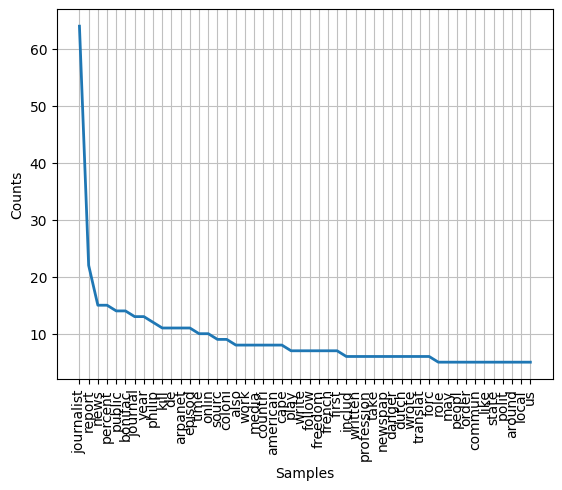

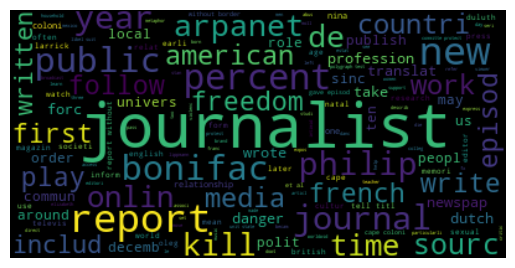

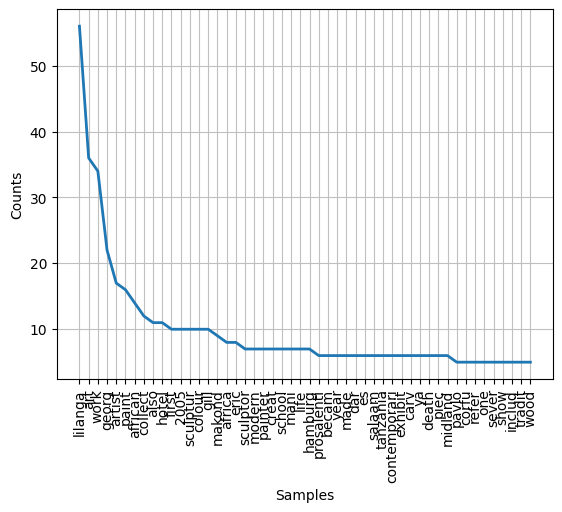

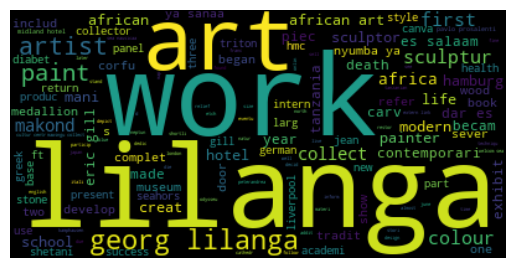

In [31]:
if __name__=='__main__':
    main()